In [55]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('Churn.csv')
print(df.head())
print(f"data shape: {df.shape}")
# Missing Values
print("DATA MISSING")
print(df.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [56]:
#Database
conn = sqlite3.connect('churn_data.db')
# 2. นำข้อมูลจาก df (ที่เราโหลดจาก csv) ใส่เข้าไปใน Database ตั้งชื่อตารางว่า 'customers'
df.to_sql('customers', conn, if_exists='replace', index=False)

print("สร้าง Database และ Table สำเร็จแล้ว! พร้อมเขียน SQL")

# --- โซนทดสอบเขียน SQL ---

# ตัวอย่างที่ 1: ลองดึงข้อมูลลูกค้า 5 คนแรกมาดู (เหมือน SELECT * LIMIT 5)
query = "SELECT * FROM customers LIMIT 5"
result = pd.read_sql(query, conn)
print("\n--- ตัวอย่างข้อมูล 5 แถวแรกจาก SQL ---")
print(result)

สร้าง Database และ Table สำเร็จแล้ว! พร้อมเขียน SQL

--- ตัวอย่างข้อมูล 5 แถวแรกจาก SQL ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic            

In [57]:
# SQL Query (Mission 1)
query_1 = """
SELECT Churn, COUNT(*) as Number_of_Customers
FROM customers
GROUP BY Churn
"""
result_1 = pd.read_sql(query_1, conn)
print("--- Result Mission 1 ---")
print(result_1)
# SQL Query (Mission 2)
#  customerID, Contract, MonthlyCharges
query_2 = """
SELECT customerID, Contract, MonthlyCharges, Churn
FROM customers
WHERE Contract = 'Month-to-month'
  AND MonthlyCharges > 70
"""

result_2 = pd.read_sql(query_2, conn)
print("\n--- Result Mission 2---")
print(result_2.head())
print(f"\nRisk group value all: {len(result_2)} ")

--- Result Mission 1 ---
  Churn  Number_of_Customers
0    No                 5174
1   Yes                 1869

--- Result Mission 2---
   customerID        Contract  MonthlyCharges Churn
0  9237-HQITU  Month-to-month           70.70   Yes
1  9305-CDSKC  Month-to-month           99.65   Yes
2  1452-KIOVK  Month-to-month           89.10    No
3  7892-POOKP  Month-to-month          104.80   Yes
4  0280-XJGEX  Month-to-month          103.70   Yes

Risk group value all: 2097 


In [58]:
sns.set_style("whitegrid")

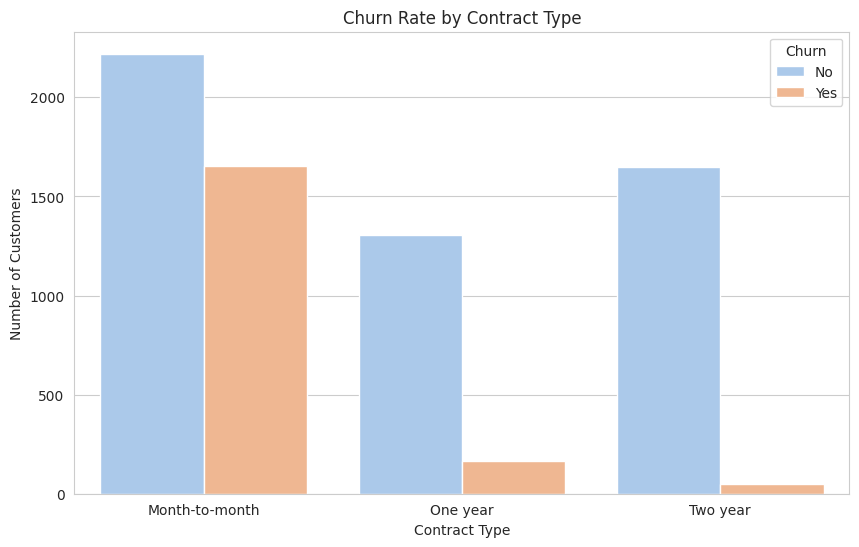

In [59]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Contract', hue='Churn', palette='pastel')

plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

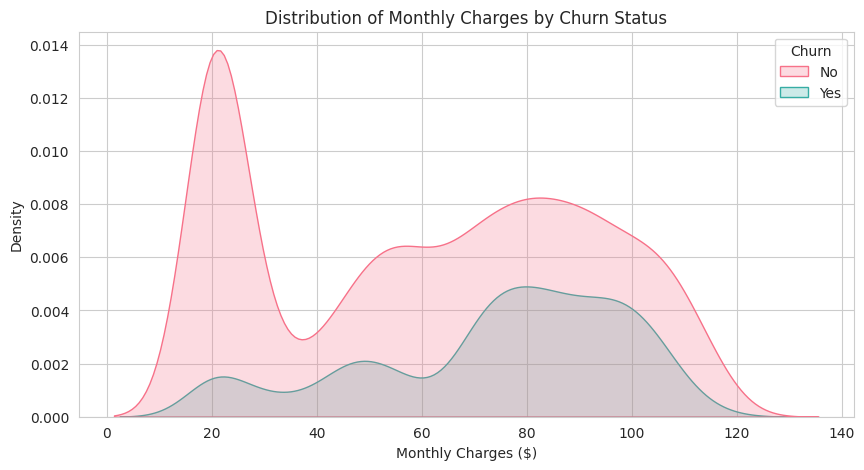

In [60]:
plt.figure(figsize=(10, 5))

# KDE Plot (Kernel Density Estimate)
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette='husl')

plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges ($)')
plt.savefig('churn_monthly_charges.png', dpi=300, bbox_inches='tight')
plt.show()

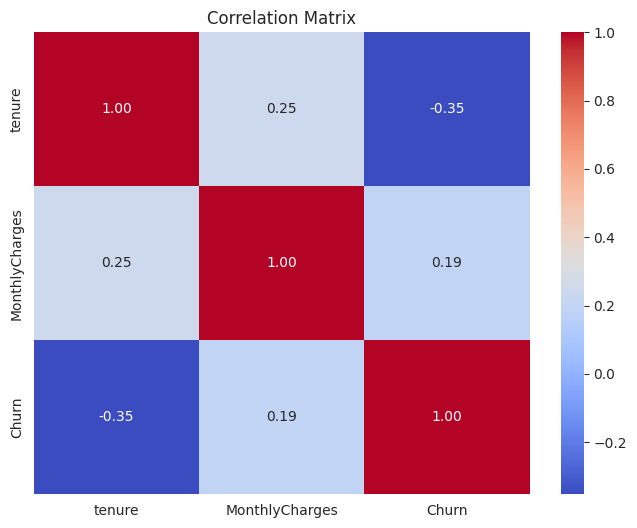

In [61]:
df_temp = df.copy()
df_temp['Churn'] = df_temp['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
numeric_cols = ['tenure', 'MonthlyCharges', 'Churn']
corr = df_temp[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [62]:
# 1. จัดการข้อมูลตัวเลขที่มีปัญหา (TotalCharges มักจะเป็น object ต้องแปลงเป็น numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True) # ลบแถวที่มีปัญหาทิ้ง (มีน้อยมาก ไม่กระทบผลลัพธ์)

# 2. ลบคอลัมน์ที่ไม่ใช้
df2 = df.drop(columns=['customerID'])
# 3. แปลงค่า Yes/No ใน Target (Churn) ให้เป็น 1/0
df2['Churn'] = df2['Churn'].map({'Yes': 1, 'No': 0})

# 4. แปลงข้อมูลที่เป็น Category ทั้งหมดให้เป็นตัวเลข (One-Hot Encoding)
# เช่น Contract จะถูกแตกเป็น Contract_Month-to-month, Contract_One year, etc.
df_encoded = pd.get_dummies(df2, drop_first=True)

print("เตรียมข้อมูลเสร็จแล้ว!")
print(f"ขนาดข้อมูลใหม่: {df_encoded.shape}")
# สังเกตว่าจำนวนคอลัมน์จะเพิ่มขึ้นเยอะเลย เพราะเราแตก category ออกมา

เตรียมข้อมูลเสร็จแล้ว!
ขนาดข้อมูลใหม่: (7032, 31)


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# X (Features) and y (Target)
X = df_encoded.drop('Churn', axis=1) # ข้อมูลสำหรับทำนาย
y = df_encoded['Churn']
#Train (80%) and Test (20%)
# random_state=42 คือการล็อคค่าสุ่ม ให้ผลลัพธ์เหมือนกันทุกครั้งที่รัน (สำคัญมากในงานวิจัย)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

#Training
model.fit(X_train, y_train)

print("train model ready")

train model ready


--- Accuracy Score ---
0.7853589196872779

--- Confusion Matrix ---


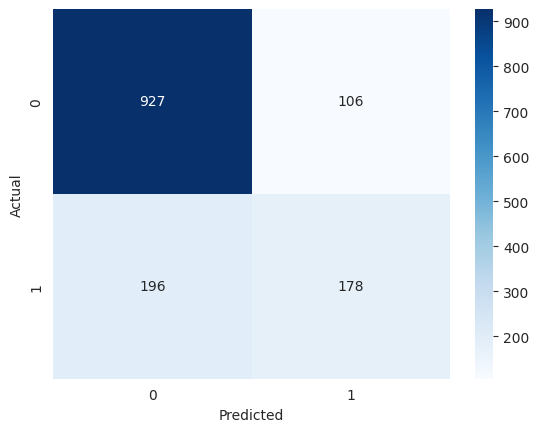


--- Classification Report (Detailed) ---
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



In [64]:
# predic X_test
y_pred = model.predict(X_test)

print("--- Accuracy Score ---")
print(accuracy_score(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n--- Classification Report (Detailed) ---")
print(classification_report(y_test, y_pred))

/tmp/ipython-input-83853944.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


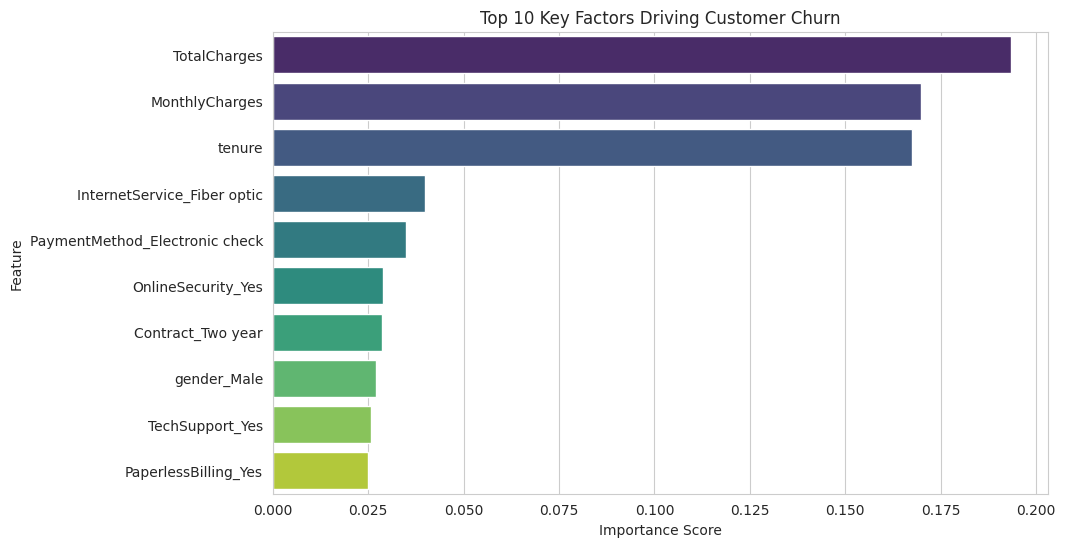

In [65]:
# Importance form Model
importances = model.feature_importances_

# Feature Names
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

#plot graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

plt.title('Top 10 Key Factors Driving Customer Churn')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()